<a href="https://colab.research.google.com/github/minassy/G-Colab/blob/main/210712_atmaCup_11_rev01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データ準備

In [1]:
import os
import zipfile

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/Competition/atmaCup_11'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data']

In [3]:
#データセットの解凍
#TARGET_PATH = 'drive/MyDrive/Competition/atmaCup_11/data/dataset_atmaCup11.zip'
#OUT_PATH = 'drive/MyDrive/Competition/atmaCup_11/data'
#with zipfile.ZipFile(TARGET_PATH, 'r') as f: 
#  f.extractall(path=OUT_PATH)

In [4]:
#os.listdir(DIR+'/data')

In [5]:
#os.mkdir(DIR + '/data/photos')

In [6]:
#photos.zipの解凍
#TARGET_PATH = 'drive/MyDrive/Competition/atmaCup_11/data/photos.zip'
#OUT_PATH = 'drive/MyDrive/Competition/atmaCup_11/data/photos'
#with zipfile.ZipFile(TARGET_PATH, 'r') as f: 
#  f.extractall(path=OUT_PATH)

In [7]:
#ディレクトリ構造
print('基本：', DIR)
print('データ：' , DIR+'/data')
print('画像データ' , DIR+'/data/photos')

基本： drive/MyDrive/Competition/atmaCup_11
データ： drive/MyDrive/Competition/atmaCup_11/data
画像データ drive/MyDrive/Competition/atmaCup_11/data/photos


# データの読み込み

In [8]:
import pandas as pd
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

テーブルデータの確認

In [9]:
os.listdir(DIR+'/data')

['dataset_atmaCup11.zip',
 'atmaCup#11_sample_submission.csv',
 'materials.csv',
 'photos.zip',
 'techniques.csv',
 'test.csv',
 'train.csv',
 'photos',
 'outputs_tutorial#1']

In [10]:
DIR_DATA = DIR+ '/data'
train_df = pd.read_csv(DIR_DATA+ '/train.csv')
test_df = pd.read_csv(DIR_DATA+ '/test.csv')
material_df = pd.read_csv(DIR_DATA+ '/materials.csv')
technique_df = pd.read_csv(DIR_DATA+ '/techniques.csv')

# データ理解(tabular)

In [11]:
from matplotlib_venn import venn2

In [12]:
#学習データ、テストデータ、マテリアル、テクニック
Dataframe = technique_df
#Dataframe.shape
#Dataframe.columns
#Dataframe.head()
#Dataframe.info()
#Dataframe.isnull().sum()

・レコード数：学習d 3937、テストd 5919、マテリアル 9081、テクニック 3777  
・キー列は、オブジェクト(絵)のID


マテリアル・テクニックのデータは、学習データのみに付与されている。これを確認する。

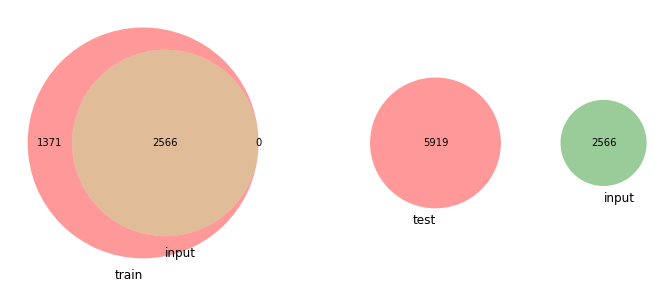

In [13]:
#テクニックのデータ
input_df = technique_df

fig, axes = plt.subplots(figsize=(12, 5), ncols=2)

venn2(subsets = (set(train_df['object_id']), set(input_df['object_id'])),
      set_labels=('train', 'input'), ax=axes[0])

venn2(subsets = (set(test_df['object_id']), set(input_df['object_id'])),
      set_labels=('test', 'input'), ax=axes[1])

・テクニックのデータは、学習データにのみ含まれている。(ただし、一部のみ)  
・テストデータには、テクニックのデータはなし。⇒この特徴量は使えるのか？

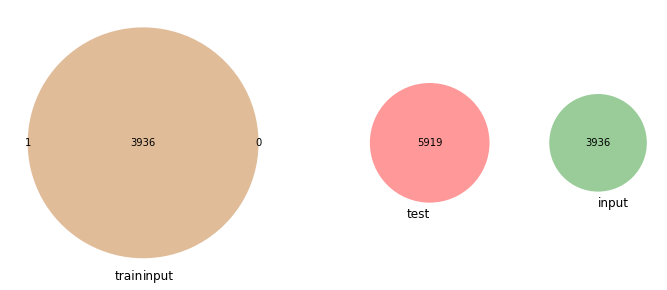

In [14]:
#マテリアルのデータ
input_df = material_df

fig, axes = plt.subplots(figsize=(12, 5), ncols=2)

venn2(subsets = (set(train_df['object_id']), set(input_df['object_id'])),
      set_labels=('train', 'input'), ax=axes[0])

venn2(subsets = (set(test_df['object_id']), set(input_df['object_id'])),
      set_labels=('test', 'input'), ax=axes[1])

・マテリアルのデータは、学習データすべてに付与できる。  
・テストデータには一切含まれていない。⇒特徴量として意味あるか？

予測対象データ(target)の確認

In [15]:
train_df.head()

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3


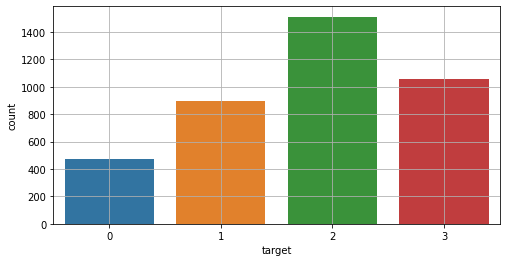

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(data=train_df, x='target', ax=ax)
ax.grid()

In [17]:
train_df['target'].value_counts().sort_index()

0     475
1     896
2    1511
3    1055
Name: target, dtype: int64

・targetは、次の順で多い 2 > 3 > 1 > 0  
・年代推定なので、恐らく'sorting_date'によってカテゴリが振られていると推定。  
  (多分、0が一番若く、3が一番新しい)

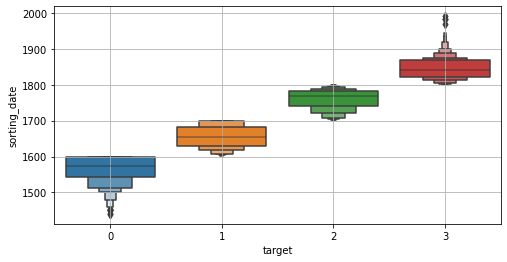

In [18]:
fig, ax = plt.subplots(figsize=(8 ,4))
sns.boxenplot(data=train_df, x='target', y='sorting_date', ax=ax)
ax.grid()

In [19]:
#ピボットテーブル作成
train_df.groupby('target')['sorting_date'].agg(['min', 'max', 'median', 'size'])

,min,max,median,size
target,,,,
0,1440,1600,1574,475
1,1601,1700,1655,896
2,1701,1800,1770,1511
3,1801,1991,1841,1055


・テストデータはオブジェクトIDしかもたないため、これまでみてきた付属データを使った予測はできない。  
⇒画像によりその年代を推定するという問題になっている。  
⇒予測に使えるメタ情報は、'sorting_date'。  
⇒画像から'sorting_date'を予測し、最終的には'target'にカテゴリ分けをして提出するタスク。

# 画像データを使用したモデルの作成

In [20]:
#!pip install ipyplot
!pip install python-vivid

     |████████████████████████████████| 76 kB 6.4 MB/s 
     |████████████████████████████████| 301 kB 53.9 MB/s 
     |████████████████████████████████| 80 kB 12.6 MB/s 
     |████████████████████████████████| 164 kB 82.5 MB/s 
     |████████████████████████████████| 75 kB 6.7 MB/s 
     |████████████████████████████████| 141 kB 75.3 MB/s 
     |████████████████████████████████| 49 kB 8.9 MB/s 
     |████████████████████████████████| 111 kB 79.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=67f688db83155999548d8be78d06587a3d40362258fe1deb339ac81edc7838d8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [21]:
import ipyplot

from PIL import Image

from torchvision import transforms as T

import torch
from torchvision.models import resnet34
from torch import nn

from torch.optim import Adam
from torch.utils import data

from torch.optim.optimizer import Optimizer
from collections import defaultdict

from vivid.utils import timer

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from tabulate import tabulate

ModuleNotFoundError: ignored

画像データの読み込み

In [22]:
photo_dir = DIR+'/data/photos'
#画像ファイルのパス設定の関数
def to_img_path(object_id):
  return os.path.join(photo_dir, f'{object_id}.jpg')

In [23]:
#画像ファイル読み込みの関数
def read_image(object_id):
  return Image.open(to_img_path(object_id))

In [24]:
#画像ファイル数
print(sum(os.path.isfile(os.path.join(photo_dir, name)) for name in os.listdir(photo_dir)), '枚')

9856 枚


In [25]:
#画像一覧を見る。
plots = train_df[train_df['target'] == 0].sample(30)['object_id'].map(lambda x: photo_dir + x + '.jpg').values

In [26]:
ipyplot.plot_images(plots)

NameError: ignored

In [ ]:
img = read_image(train_df['object_id'].iat[3936])

In [ ]:
img

データ拡張

なぜデータ拡張が必要か？  
⇒予測の不変性を確保したいため。多少ズレたり反転したりするくらいで予測を外して欲しくないため。  
⇒データ拡張は、これに対処するための一つの手段である。  
【データ拡張の種類】  
①左右入れ替え  
②上下入れ替え  
③ランダムな画像の切り出し  
④色相変化

In [ ]:
T.RandomVerticalFlip(p=1)(img)

In [ ]:
T.RandomHorizontalFlip(p=1)(img)

In [ ]:
T.RandomGrayscale(1)(img)

In [ ]:
#明度、コントラスト、彩度をランダムに変動
T.ColorJitter(brightness=.3, contrast=.5, saturation=[.8, 1.3])(img)

In [ ]:
T.RandomResizedCrop(size=(200, 200), )(img)

In [ ]:
#並べた順に変換器を適用する。
converter = T.Compose([
                       T.RandomVerticalFlip(p=1),
                       T.ColorJitter(brightness=.5, contrast=.5)
])
converter(img)

モデルの定義

In [ ]:
model = resnet34(pretrained=False)#事前学習は無し。

In [ ]:
#model

In [ ]:
converter = T.Compose([
                       T.RandomHorizontalFlip(p=1),
                       T.ColorJitter(brightness=.5, contrast=.5),
                       T.ToTensor()
])

In [ ]:
x = converter(img)

In [ ]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
type(x)

torch.Tensor

T.ToTensorにて、pytorchで扱えるテンソル化

In [ ]:
x.shape

torch.Size([3, 165, 224])

In [ ]:
x.unsqueeze(0).shape

torch.Size([1, 3, 165, 224])

In [ ]:
output = model(x.unsqueeze(0))

In [ ]:
output.shape

torch.Size([1, 1000])

・タスクの出力は"年代"の一次元なので、最終層を書き換え。

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

In [ ]:
model(x.unsqueeze(0))

tensor([[0.6207]], grad_fn=<AddmmBackward>)

以上より、モデル(Resnet34)を使った予測値の出力ができるようになった。  
ただし、ただのランダムな出力になるだけなので、  
Xを入れたときの年代yを出力する、というように修正をおこなう。  

# 学習スキームの定義

①入力データxをモデルに入れ、出力zを作成  
②あるxに対応する正解ラベルyとzを目的関数(今回はRMSE)に入れ、ズレ量(loss)を計算  
③lossの情報を基にし、最適化手法によりモデルを更新

目的関数の定義

In [ ]:
criterion = nn.MSELoss()

In [ ]:
#最適化手法の定義。
optimizer = Adam(params=model.parameters(), lr=1e-3)
#第一引数；どのモデルのパラメータを更新したいかを指定。
#第二引数：LearningRate。決まった値はないが、adamの場合、1e-3がよく使われるらしい。

モデルの学習(画像一枚)

①学習データをtorch.Tensorの形式で用意する。

In [ ]:
x = converter(img)
x = x.unsqueeze(0)

In [ ]:
label = train_df['target'].iat[0]
label = torch.Tensor(label)
label = label.reshape(-1, 1)

②学習データをモデルに入れ、lossを目的関数で計算

In [ ]:
output = model(x)

In [ ]:
loss = criterion(output, label)

③loss値から、optimizerがmodelを更新する

In [ ]:
# zero_grad は今ある勾配の情報をリセットする関数. このあとに計算される勾配を元にして最適化される
optimizer.zero_grad()

In [ ]:
#lossから勾配計算
loss.backward()

In [ ]:
#最適化ステップを1つ進める。
optimizer.step()

In [ ]:
print(loss.item())

0.3181387186050415


学習の関数化

In [ ]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

In [ ]:
class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "target"

    @property
    def meta_keys(self):
        retval = [self.object_path_key]

        if self.is_train:
            retval += [self.label_key]

        return retval

    def __init__(self, meta_df: pd.DataFrame, is_train=True):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります

            is_train:
                True のとき学習用のデータ拡張を適用します.
                False の時は単に size にリサイズを行います
        """

        self.is_train = is_train
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError("meta df must have {}".format(k))

        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")

        size = (224, 224)

        additional_items = (
            [T.Resize(size)]
            if not is_train
            else [
                T.RandomGrayscale(p=0.2),
                T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                T.ColorJitter(
                    brightness=0.3,
                    contrast=0.5,
                    saturation=[0.8, 1.3],
                    hue=[-0.05, 0.05],
                ),
                T.RandomResizedCrop(size),
            ]
        )

        self.transformer = T.Compose(
            [*additional_items, T.ToTensor(), T.Normalize(mean=IMG_MEAN, std=IMG_STD)]
        )

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = Image.open(obj_path)
        img = self.transformer(img)
        return img, label

    def __len__(self):
        return len(self.meta_df)

In [ ]:
train_meta_df = train_df[['target', 'object_id']].copy()
train_meta_df['object_path'] = train_meta_df['object_id'].map(to_img_path)

dataset = AtmaDataset(meta_df=train_meta_df)

In [ ]:
# この場合同時に 54 個の画像に対応した tensor と label が作られる
loader = data.DataLoader(dataset=dataset, batch_size=54, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
  for x_tensor, y in loader:
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#最初の次元が、設定したバッチサイズ54になっていることを確認。
x_tensor.shape, y.shape

(torch.Size([54, 3, 224, 224]), torch.Size([54]))

学習関数の実装

In [ ]:
assert torch.cuda.is_available()

DEVICE = torch.device('cuda')

In [ ]:
def train(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: data.DataLoader
) -> pd.Series:

    # train にすることで model 内の学習時にのみ有効な機構が有効になります (Dropouts Layers、BatchNorm Layers...)
    model.train()

    criterion = nn.MSELoss()

    # ロスの値を保存する用に dict を用意
    metrics = defaultdict(float)
    n_iters = len(train_loader)

    for i, (x_i, y_i) in enumerate(train_loader):
        x_i = x_i.to(DEVICE)
        y_i = y_i.to(DEVICE).reshape(-1, 1).float()

        output = model(x_i)
        loss = criterion(output, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metric_i = {
            # loss は tensor object なので item をつかって python object に戻す
            "loss": loss.item()
        }
        for k, v in metric_i.items():
            metrics[k] += v

    for k, v in metrics.items():
        metrics[k] /= n_iters

    return pd.Series(metrics).add_prefix("train_")

In [ ]:
n_epochs = 10

# GPU 環境で学習するため変換. この呼び出しは破壊的
model.to(DEVICE)
optimizer = Adam(params=model.parameters(), lr=1e-3)

for epoch in range(1, n_epochs + 1):

    with timer(prefix="train: epoch={}".format(epoch)):
        score_train = train(
            model, optimizer, train_loader=loader
        )
    print(score_train)

    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=1 28.731[s]
train_loss    2.062666
dtype: float64


# 交差検証

In [ ]:
fold = KFold(n_splits=5, shuffle=True, random_state=510)
cv = list(fold.split(X=train_df, y=train_df['target']))

In [ ]:
idx_tr, idx_val = cv[0]

len(idx_tr), len(idx_val)

(3149, 788)

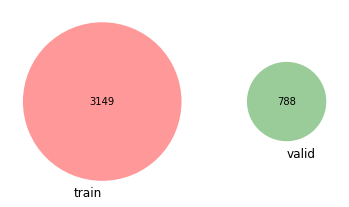

In [ ]:
# train / valid で index の重複はない
venn2(subsets=(set(idx_tr), set(idx_val)), set_labels=('train', 'valid'))

In [ ]:
# 最初の fold だけで考える
#⇒見積もりの正確性は落ちるが、たくさんの実験パターンを実行できるメリットがある。
#特に、一つの fold の学習に時間がかかる場合、実験条件のPDCAを回す速度を優先しfold を削ることがある。
cv = cv[:1]

検証の実装

predict: 与えられたデータ (data-loader) に対しての予測値を計算  
valid: 与えられたモデル・データローダを使って検証フェーズを実行。  
スコアの dict と予測した値を返す

In [ ]:
def predict(model: nn.Module, loader: data.DataLoader) -> np.ndarray:
    # train とは逆で model 内の学習時にのみ有効な機構がオフになります (Dropouts Layers、BatchNorm Layers...)
    model.eval()

    predicts = []

    for x_i, y_i in loader:

        # 明示的に勾配を計算しないように指定することができます. 
        # この関数ではモデルの更新はせずに単に出力だけを使いますので勾配は不要です.
        with torch.no_grad():
            output = model(x_i.to(DEVICE))

        predicts.extend(output.data.cpu().numpy())

    pred = np.array(predicts).reshape(-1)
    return pred


def calculate_metrics(y_true, y_pred) -> dict:
    """正解ラベルと予測ラベルから指標を計算する"""
    # return regression_metrics(y_true, y_pred)

    return {
        'rmse': mean_squared_error(y_true, y_pred) ** .5
    }


def valid(
    model: nn.Module, 
    y_valid: np.ndarray, 
    valid_loader: data.DataLoader
) -> pd.Series:
    """検証フェーズ
    与えられたモデル・データローダを使って検証フェーズを実行。スコアの dict と予測した値を返す
    """

    pred = predict(model, valid_loader)
    score = calculate_metrics(y_valid, pred)

    valid_score = pd.Series(score)
    return valid_score.add_prefix("valid_"), pred

In [ ]:
def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    output_dir: str, 
    n_epochs=30) -> np.ndarray:
    """
    train / valid に分割されたデータで学習と同時に検証を行なう
    """

    os.makedirs(output_i, exist_ok=True)

    optimizer = Adam(model.parameters(), lr=1e-3)

    # 0: 前準備. dataframe から data loader を作成
    train_dataset = AtmaDataset(meta_df=train_df)
    # 検証用の方は is_train=False にしてデータ拡張オフにする
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)

    train_loader = data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4
    )
    valid_loader = data.DataLoader(valid_dataset, batch_size=256, num_workers=4)

    # --- 保存のための変数定義
    score_df = pd.DataFrame()
    valid_score = np.inf
    valid_score_key = "valid_rmse"
    valid_best_pred = None

    for epoch in range(1, n_epochs + 1):
        print(f'start {epoch}')

        # 1: 学習用データで学習を実行。学習時のロスを取得
        with timer(prefix="train: epoch={}".format(epoch)):
            score_train = train(
                model, optimizer, train_loader
            )

        # 2: 検証データでのスコアを計算
        with timer(prefix="validate"):
            score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)


        # --- 学習のロスと検証スコアの値をデータフレームに追加
        row = pd.concat([score_train, score_valid])
        row["epoch"] = epoch
        row = pd.DataFrame([row])
        print(tabulate(row, headers=row.columns))
        score_df = pd.concat([score_df, row], ignore_index=True)
        # ---

        # 今の検証スコアと過去最高のスコアを比較
        current_score = score_valid[valid_score_key]
        if current_score < valid_score:
            # スコア改善したときモデルを保存する
            print(f'validation score is improved!! {valid_score:.4f} -> {current_score:.4f}')
            torch.save(
                model.state_dict(), os.path.join(output_dir, 'model_best.pth')
            )
            valid_score = current_score
            valid_best_pred = y_valid_pred

    score_df.to_csv(os.path.join(output_dir, 'score.csv'), index=False)
    return valid_best_pred

CrossValidationの枠組みで学習の実行

In [ ]:
output_dir = os.path.join(DIR+'/data', "outputs_tutorial#1")
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def get_output_dir(n_cv: int):
    return os.path.join(output_dir, 'simple_resnet', f'cv={n_cv}')

oof = np.zeros((len(train_df), ), dtype=np.float32)

for i, (idx_tr, idx_valid) in enumerate(cv):
    output_i = get_output_dir(i)
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

    model.to(DEVICE)

    oof_i = run_fold(
        model=model, 
        train_df=train_meta_df.iloc[idx_tr], 
        valid_df=train_meta_df.iloc[idx_valid], 
        y_valid=train_meta_df['target'].values[idx_valid],
        output_dir=output_i,

        # 今は 1 ですぐ終わるようにしている. 本当は validation score の値を見つつ適宜設定する
        n_epochs=1
    )

    oof[idx_valid] = oof_i

start 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=1 22.182[s]
validate 3.770[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       2.91602       1.01284        1
validation score is improved!! inf -> 1.0128


FoldOutした予測値でのスコア確認

In [ ]:
calculate_metrics(train_df['target'], oof)

{'rmse': 1.8832018440982148}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


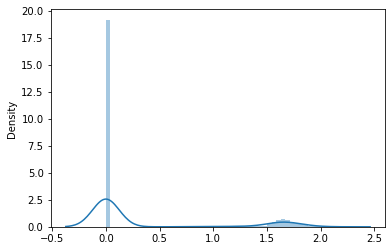

In [ ]:
sns.distplot(oof)

# Submission を作る

In [ ]:
def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)

    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

# train と似たようなことをするので、次回から楽したいとおもって `create_metadata` という関数を作りました
test_meta_df = create_metadata(test_df)

# 学習時のデータ拡張はオフにしたいので is_train=False としている
test_dataset = AtmaDataset(meta_df=test_meta_df, is_train=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_predictions = []

for i in range(len(cv)):
    output_i = get_output_dir(i)

    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

    # 最も良かった重みを読みだす
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    model_path = os.path.join(output_i, 'model_best.pth')

    model.load_state_dict(torch.load(model_path))

    # GPU環境で予測するため `to` で変換
    model.to(DEVICE)

    with timer(prefix=f'pred cv={i}'):
        y_pred_i = predict(model, loader=test_loader)

    test_predictions.append(y_pred_i)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


pred cv=0 424.737[s]


submission file として保存

In [ ]:
# すべての予測の平均値を使う
pred_mean = np.array(test_predictions).mean(axis=0)

pd.DataFrame({
    "target": pred_mean
}).to_csv(os.path.join(output_dir, "0001__submission.csv"), index=False)